In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import KFold

In [38]:
df=pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")

In [39]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [40]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [41]:
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(exclude=['object']).columns

df[categorical_cols] = df[categorical_cols].fillna('NA')
df[numerical_cols] = df[numerical_cols].fillna(0.0)

In [42]:
X = df.drop("converted", axis=1)
y = df["converted"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, train_size=0.6, random_state=1, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, train_size=0.5, random_state=1, stratify=y_temp)

In [43]:
numerical_features = [
    'lead_score',
    'number_of_courses_viewed',
    'interaction_count',
    'annual_income'
]
aucs = {}

for feature in numerical_features:
    scores = X_train[feature]
    auc = roc_auc_score(y_train, scores)
    if auc < 0.5:
        auc = roc_auc_score(y_train, -scores)
    aucs[feature] = auc

for feature, auc in aucs.items():
    print(f"{feature}: {auc:.4f}")

highest_auc_feature = max(aucs, key=aucs.get)
print('Highest AUC variable:', highest_auc_feature, 'with AUC:', aucs[highest_auc_feature])

lead_score: 0.6107
number_of_courses_viewed: 0.7648
interaction_count: 0.7227
annual_income: 0.5545
Highest AUC variable: number_of_courses_viewed with AUC: 0.7648046448539385


In [44]:
X_train_dict = X_train.to_dict(orient='records')
X_val_dict = X_val.to_dict(orient='records')

In [45]:
dv = DictVectorizer(sparse=False)
X_train_encoded = dv.fit_transform(X_train_dict)
X_val_encoded = dv.transform(X_val_dict)

In [46]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [47]:
y_val_pred = model.predict_proba(X_val_encoded)[:, 1]
auc = roc_auc_score(y_val, y_val_pred)
print('Validation AUC:', round(auc, 3))

Validation AUC: 0.866


In [48]:
thresholds = np.arange(0.0, 1.01, 0.01)
precision = []
recall = []

for t in thresholds:
    preds = (y_val_pred >= t).astype(int)
    precision.append(precision_score(y_val, preds, zero_division=0))
    recall.append(recall_score(y_val, preds))

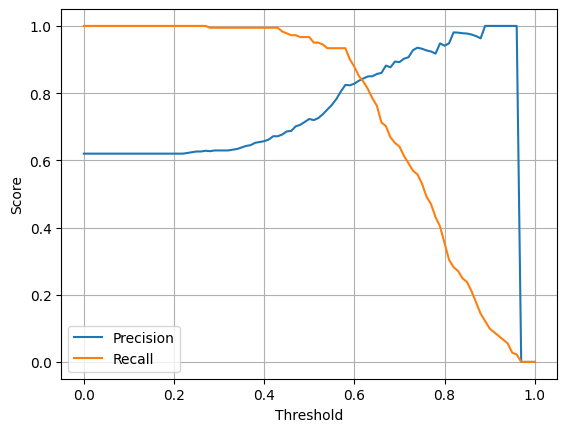

In [49]:
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
precision = np.array(precision)
recall = np.array(recall)
diff = np.abs(precision - recall)
intersection_idx = np.argmin(diff)
intersection_threshold = thresholds[intersection_idx]
print("Intersection threshold: ", round(intersection_threshold, 3))

Intersection threshold:  0.97


In [51]:
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []
f1_scores = []

for t in thresholds:
    preds = (y_val_pred >= t).astype(int)
    p = precision_score(y_val, preds, zero_division=0)
    r = recall_score(y_val, preds)
    precisions.append(p)
    recalls.append(r)
    
    if (p + r) == 0:
        f1 = 0
    else:
        f1 = 2 * p * r / (p + r)
    f1_scores.append(f1)

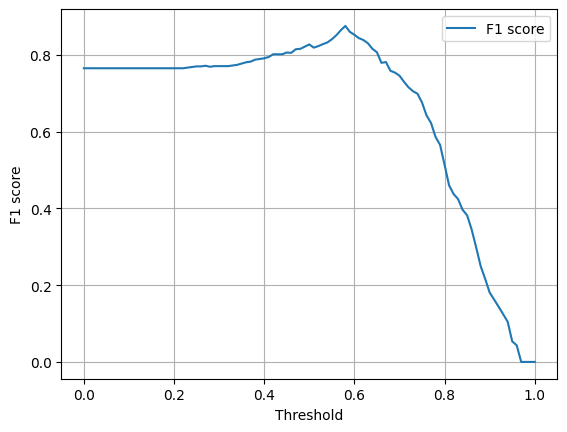

In [52]:
plt.plot(thresholds, f1_scores, label='F1 score')
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.grid(True)
plt.legend()
plt.show()

In [53]:
f1_scores = np.array(f1_scores)
max_idx = f1_scores.argmax()
max_f1_threshold = thresholds[max_idx]
print("Threshold where F1 is maximal:", round(max_f1_threshold, 2))

Threshold where F1 is maximal: 0.58


In [56]:
df_full_train=df.copy()

In [58]:
target_col = "converted"

In [59]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
aucs = []

for train_idx, val_idx in kf.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train[target_col].values
    y_val = df_val[target_col].values
    X_train = df_train.drop(columns=[target_col])
    X_val = df_val.drop(columns=[target_col])
    
    dv = DictVectorizer(sparse=False)
    X_train_dict = X_train.to_dict(orient='records')
    X_val_dict = X_val.to_dict(orient='records')
    X_train_encoded = dv.fit_transform(X_train_dict)
    X_val_encoded = dv.transform(X_val_dict)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_encoded, y_train)
    
    y_val_pred = model.predict_proba(X_val_encoded)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)
    aucs.append(auc)

In [60]:
std_auc = np.std(aucs)
print("Standard deviation of AUCs:", std_auc)

Standard deviation of AUCs: 0.028845510405609943
